In [22]:
import selfies as sf
import pathlib as Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader

In [6]:
mof_dataset = pd.read_csv(r"C:\Users\dalja\OneDrive\Desktop\APS360 Project\Code\merged_mof_dataset.csv")

In [7]:
mof_dataset.columns

Index(['LCD', 'PLD', 'LFPD', 'cm3_g', 'ASA_m2_cm3', 'ASA_m2_g', 'NASA_m2_cm3',
       'NASA_m2_g', 'AV_VF', 'AV_cm3_g', 'NAV_cm3_g', 'MOFid', 'metal',
       'linker', 'OMS_flag', 'logKH_CO2', 'pure_uptake_CO2_298.00_15000',
       'pure_uptake_methane_298.00_6500000', 'metal_ids', 'linker_ids',
       'metal_oms_flags'],
      dtype='object')

In [8]:
def simple_split(df, target_col='logKH_CO2', test_size=0.1, val_size=0.1, random_state=42):
    """
    타겟 분포를 고려해서 데이터 나누기
    
    df: 데이터프레임
    target_col: 중요한 타겟 컬럼 (이 값의 분포가 골고루 나뉨)
    test_size: 테스트 비율 (0.1 = 10%)
    val_size: 검증 비율 (0.1 = 10%)
    """
    # 타겟을 5개 구간으로 나눔 (낮음, 중하, 중간, 중상, 높음)
    df['_group'] = pd.qcut(df[target_col], q=5, labels=False, duplicates='drop')
    
    # 1단계: Train+Val vs Test 분리
    train_val, test = train_test_split(
        df, 
        test_size=test_size,
        stratify=df['_group'],  # 각 구간에서 골고루 뽑기
        random_state=random_state
    )
    
    # 2단계: Train vs Val 분리
    val_ratio = val_size / (1 - test_size)  # 남은 데이터에서 val 비율 계산
    train, val = train_test_split(
        train_val,
        test_size=val_ratio,
        stratify=train_val['_group'],
        random_state=random_state
    )
    
    # 임시로 만든 '_group' 컬럼 삭제
    train = train.drop(columns=['_group'])
    val = val.drop(columns=['_group'])
    test = test.drop(columns=['_group'])
    
    # 결과 출력
    print(f"Train: {len(train)} ({len(train)/len(df)*100:.1f}%)")
    print(f"Val:   {len(val)} ({len(val)/len(df)*100:.1f}%)")
    print(f"Test:  {len(test)} ({len(test)/len(df)*100:.1f}%)")
    print(f"\n{target_col} 평균:")
    print(f"Train: {train[target_col].mean():.3f}")
    print(f"Val:   {val[target_col].mean():.3f}")
    print(f"Test:  {test[target_col].mean():.3f}")
    
    return train, val, test


# 사용 - 한 줄!
train_df, val_df, test_df = simple_split(
    mof_dataset, 
    target_col='logKH_CO2',  # 가장 중요한 타겟 하나만
    test_size=0.1,           # 10% 테스트
    val_size=0.1             # 10% 검증
)

# 저장
train_df.to_csv('train_mof.csv', index=False)
val_df.to_csv('val_mof.csv', index=False)
test_df.to_csv('test_mof.csv', index=False)

Train: 2665 (80.0%)
Val:   334 (10.0%)
Test:  334 (10.0%)

logKH_CO2 평균:
Train: -0.001
Val:   -0.006
Test:  0.016


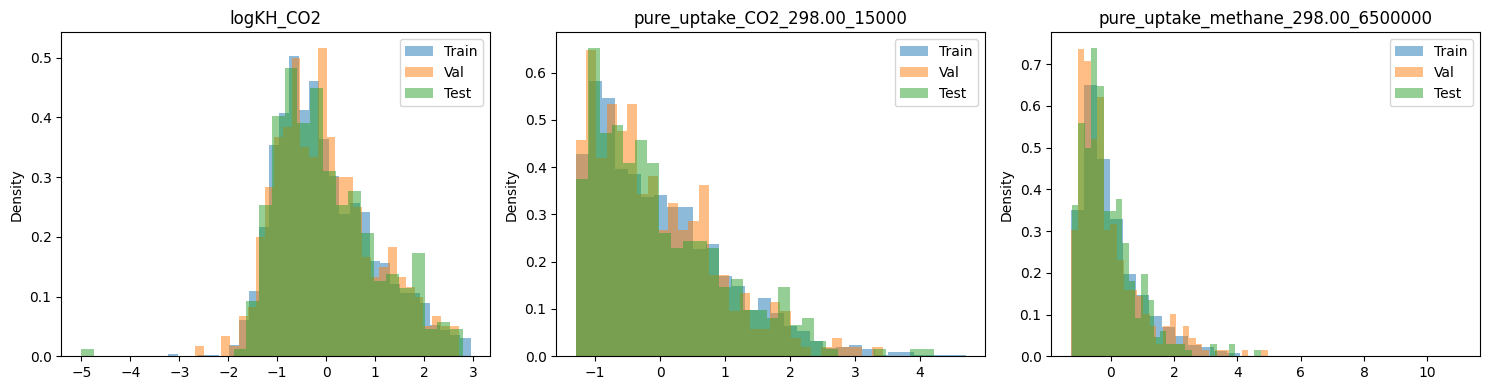

In [9]:
def plot_split_distributions(train_df, val_df, test_df, columns):
    """Train/Val/Test 분포 시각적 비교"""
    fig, axes = plt.subplots(1, len(columns), figsize=(5*len(columns), 4))
    if len(columns) == 1:
        axes = [axes]
    
    for i, col in enumerate(columns):
        axes[i].hist(train_df[col], alpha=0.5, label='Train', bins=30, density=True)
        axes[i].hist(val_df[col], alpha=0.5, label='Val', bins=30, density=True)
        axes[i].hist(test_df[col], alpha=0.5, label='Test', bins=30, density=True)
        axes[i].set_title(col)
        axes[i].legend()
        axes[i].set_ylabel('Density')
    
    plt.tight_layout()
    plt.show()


plot_split_distributions(
    train_df, 
    val_df, 
    test_df, 
    columns=['logKH_CO2', 'pure_uptake_CO2_298.00_15000', 'pure_uptake_methane_298.00_6500000']
)

In [10]:
import ast

class MOFDataset(Dataset):
    """MOF 데이터셋 - 문자열 리스트 처리"""
    
    def __init__(self, df, geometry_cols, target_cols):
        self.df = df.reset_index(drop=True)
        self.geometry_cols = geometry_cols
        self.target_cols = target_cols
        
        # Geometry/Target 숫자형 변환
        for col in geometry_cols + target_cols:
            self.df[col] = pd.to_numeric(self.df[col], errors='coerce').fillna(0)
        
        # 문자열 리스트를 실제 리스트로 변환
        if 'metal' in self.df.columns:
            self.df['metal_ids'] = self.df['metal'].apply(
                lambda x: ast.literal_eval(x) if isinstance(x, str) else x
            )
        if 'linker' in self.df.columns:
            self.df['linker_ids'] = self.df['linker'].apply(
                lambda x: ast.literal_eval(x) if isinstance(x, str) else x
            )
        if 'OMS_flag' in self.df.columns:
            self.df['metal_oms_flags'] = self.df['OMS_flag'].apply(
                lambda x: ast.literal_eval(x) if isinstance(x, str) else x
            )
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        geometry = torch.tensor(
            row[self.geometry_cols].values.astype(np.float32), 
            dtype=torch.float32
        )
        
        metal_ids = torch.tensor(
            row['metal_ids'], 
            dtype=torch.long
        )
        
        metal_oms = torch.tensor(
            row['metal_oms_flags'], 
            dtype=torch.float32
        )
        
        linker_ids = torch.tensor(
            row['linker_ids'], 
            dtype=torch.long
        )
        
        targets = torch.tensor(
            row[self.target_cols].values.astype(np.float32), 
            dtype=torch.float32
        )
        
        return {
            'geometry': geometry,
            'metal_ids': metal_ids,
            'metal_oms': metal_oms,
            'linker_ids': linker_ids,
            'targets': targets
        }



In [11]:
geometry_cols = ['LCD', 'PLD', 'LFPD', 'cm3_g', 'ASA_m2_cm3', 'ASA_m2_g', 
                 'NASA_m2_cm3', 'NASA_m2_g', 'AV_VF', 'AV_cm3_g', 'NAV_cm3_g']

target_cols = ['logKH_CO2', 'pure_uptake_CO2_298.00_15000', 
               'pure_uptake_methane_298.00_6500000']

# 재생성
train_dataset = MOFDataset(train_df, geometry_cols, target_cols)
val_dataset = MOFDataset(val_df, geometry_cols, target_cols)
test_dataset = MOFDataset(test_df, geometry_cols, target_cols)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 84
Val batches: 11
Test batches: 11


In [12]:
import torch
import torch.nn as nn

class SimpleBaselineModel(nn.Module):
    """
    간단한 baseline: 각 modality를 MLP로 인코딩 → concat → predict
    
    구조:
    Geometry → MLP → embedding
    Metal → Embedding → MLP → embedding  
    Linker → Embedding → MLP → embedding
    → Concat → MLP → 3 outputs
    """
    def __init__(self, 
                 n_geometry=11,
                 metal_vocab_size=33,
                 linker_vocab_size=86,
                 max_metals=5,
                 max_linker_len=198,
                 hidden_dim=128):
        super().__init__()
        
        # 1. Geometry encoder (MLP)
        self.geometry_encoder = nn.Sequential(
            nn.Linear(n_geometry, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        
        # 2. Metal encoder
        self.metal_embedding = nn.Embedding(metal_vocab_size, hidden_dim)
        self.metal_encoder = nn.Sequential(
            nn.Linear(max_metals * hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        
        # 3. Linker encoder
        self.linker_embedding = nn.Embedding(linker_vocab_size, hidden_dim)
        self.linker_encoder = nn.Sequential(
            nn.Linear(max_linker_len * hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        
        # 4. Fusion & prediction
        self.predictor = nn.Sequential(
            nn.Linear(hidden_dim * 3, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, 3)  # 3 targets
        )
    
    def forward(self, geometry, metal_ids, metal_oms, linker_ids):
        # Encode geometry
        geo_emb = self.geometry_encoder(geometry)  # (batch, hidden_dim)
        
        # Encode metals
        metal_emb = self.metal_embedding(metal_ids)  # (batch, max_metals, hidden_dim)
        metal_emb = metal_emb.view(metal_emb.size(0), -1)  # Flatten
        metal_emb = self.metal_encoder(metal_emb)  # (batch, hidden_dim)
        
        # Encode linker
        linker_emb = self.linker_embedding(linker_ids)  # (batch, max_linker_len, hidden_dim)
        linker_emb = linker_emb.view(linker_emb.size(0), -1)  # Flatten
        linker_emb = self.linker_encoder(linker_emb)  # (batch, hidden_dim)
        
        # Concatenate all
        combined = torch.cat([geo_emb, metal_emb, linker_emb], dim=1)  # (batch, hidden_dim*3)
        
        # Predict
        output = self.predictor(combined)  # (batch, 3)
        return output


# 사용
model = SimpleBaselineModel(
    n_geometry=11,
    metal_vocab_size=33,  # 당신의 metal vocab size
    linker_vocab_size=86,
    max_metals=5,
    max_linker_len=198,
    hidden_dim=128
)

print(model)
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

SimpleBaselineModel(
  (geometry_encoder): Sequential(
    (0): Linear(in_features=11, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
  (metal_embedding): Embedding(33, 128)
  (metal_encoder): Sequential(
    (0): Linear(in_features=640, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
  (linker_embedding): Embedding(86, 128)
  (linker_encoder): Sequential(
    (0): Linear(in_features=25344, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
  (predictor): Sequential(
    (0): Linear(in_features=384, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=128, out_features=3, bias=True)
  )
)
Total parameters: 3,442,179


In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def train_model(model, train_loader, val_loader, num_epochs=50, lr=0.001, device='cuda'):
    """
    모델 학습 + loss/metric 기록
    
    Returns:
        history: 학습 기록 (loss, metrics)
    """
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # 기록용
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_mae': [],
        'val_r2': []
    }
    
    for epoch in range(num_epochs):
        # ===== Training =====
        model.train()
        train_loss = 0
        
        for batch in train_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            
            # Forward
            outputs = model(
                geometry=batch['geometry'],
                metal_ids=batch['metal_ids'],
                metal_oms=batch['metal_oms'],
                linker_ids=batch['linker_ids']
            )
            
            loss = criterion(outputs, batch['targets'])
            
            # Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_loader)
        
        # ===== Validation =====
        model.eval()
        val_loss = 0
        all_preds = []
        all_targets = []
        
        with torch.no_grad():
            for batch in val_loader:
                batch = {k: v.to(device) for k, v in batch.items()}
                
                outputs = model(
                    batch['geometry'], 
                    batch['metal_ids'], 
                    batch['metal_oms'], 
                    batch['linker_ids']
                )
                
                loss = criterion(outputs, batch['targets'])
                val_loss += loss.item()
                
                # 예측값 수집
                all_preds.append(outputs.cpu().numpy())
                all_targets.append(batch['targets'].cpu().numpy())
        
        avg_val_loss = val_loss / len(val_loader)
        
        # 예측 성능 계산
        all_preds = np.concatenate(all_preds, axis=0)
        all_targets = np.concatenate(all_targets, axis=0)
        
        mae = mean_absolute_error(all_targets, all_preds)
        r2 = r2_score(all_targets, all_preds)
        
        # 기록
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['val_mae'].append(mae)
        history['val_r2'].append(r2)
        
        # 출력
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{num_epochs} - "
                  f"Train Loss: {avg_train_loss:.4f}, "
                  f"Val Loss: {avg_val_loss:.4f}, "
                  f"Val MAE: {mae:.4f}, "
                  f"Val R²: {r2:.4f}")
    
    return history


def plot_training_history(history):
    """학습 곡선 시각화"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # Loss
    axes[0].plot(history['train_loss'], label='Train Loss')
    axes[0].plot(history['val_loss'], label='Val Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss (MSE)')
    axes[0].set_title('Training & Validation Loss')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    # MAE
    axes[1].plot(history['val_mae'], color='orange')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('MAE')
    axes[1].set_title('Validation MAE')
    axes[1].grid(alpha=0.3)
    
    # R²
    axes[2].plot(history['val_r2'], color='green')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('R²')
    axes[2].set_title('Validation R²')
    axes[2].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()


def evaluate_model(model, test_loader, target_names, device='cuda'):
    """
    테스트셋 평가 + 타겟별 성능
    
    target_names: ['logKH_CO2', 'pure_uptake_CO2', 'pure_uptake_CH4']
    """
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for batch in test_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            
            outputs = model(
                batch['geometry'], 
                batch['metal_ids'], 
                batch['metal_oms'], 
                batch['linker_ids']
            )
            
            all_preds.append(outputs.cpu().numpy())
            all_targets.append(batch['targets'].cpu().numpy())
    
    all_preds = np.concatenate(all_preds, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)
    
    # 전체 성능
    print("="*50)
    print("전체 성능:")
    print(f"  MAE:  {mean_absolute_error(all_targets, all_preds):.4f}")
    print(f"  RMSE: {np.sqrt(mean_squared_error(all_targets, all_preds)):.4f}")
    print(f"  R²:   {r2_score(all_targets, all_preds):.4f}")
    
    # 타겟별 성능
    print("\n" + "="*50)
    print("타겟별 성능:")
    for i, name in enumerate(target_names):
        mae = mean_absolute_error(all_targets[:, i], all_preds[:, i])
        rmse = np.sqrt(mean_squared_error(all_targets[:, i], all_preds[:, i]))
        r2 = r2_score(all_targets[:, i], all_preds[:, i])
        
        print(f"\n{name}:")
        print(f"  MAE:  {mae:.4f}")
        print(f"  RMSE: {rmse:.4f}")
        print(f"  R²:   {r2:.4f}")
    
    # Scatter plot (예측 vs 실제)
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    for i, name in enumerate(target_names):
        axes[i].scatter(all_targets[:, i], all_preds[:, i], alpha=0.5)
        axes[i].plot([all_targets[:, i].min(), all_targets[:, i].max()], 
                     [all_targets[:, i].min(), all_targets[:, i].max()], 
                     'r--', lw=2)
        axes[i].set_xlabel('actual value')
        axes[i].set_ylabel('predicted value')
        axes[i].set_title(f'{name}\nR² = {r2:.3f}')
        axes[i].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return all_preds, all_targets



In [15]:
# 직접 확인
import joblib

metal_vocab = joblib.load('metal_vocabulary.pkl')
print(f"Metal vocab type: {type(metal_vocab)}")
print(f"Metal vocab: {metal_vocab}")

linker_vocab = joblib.load('linker_vocabulary.pkl')
print(f"\nLinker data type: {type(linker_vocab)}")
print(f"Linker data keys: {linker_vocab.keys() if isinstance(linker_vocab, dict) else 'Not a dict'}")

Metal vocab type: <class 'dict'>
Metal vocab: {'Ag': 0, 'Al': 1, 'Au': 2, 'Ba': 3, 'Be': 4, 'Bi': 5, 'Ca': 6, 'Cd': 7, 'Ce': 8, 'Co': 9, 'Cr': 10, 'Cs': 11, 'Cu': 12, 'Dy': 13, 'Er': 14, 'Eu': 15, 'Fe': 16, 'Ga': 17, 'Gd': 18, 'Hf': 19, 'Ho': 20, 'In': 21, 'Ir': 22, 'K': 23, 'La': 24, 'Li': 25, 'Lu': 26, 'Mg': 27, 'Mn': 28, 'Mo': 29, 'Na': 30, 'Nb': 31, 'Nd': 32, 'Ni': 33, 'Pb': 34, 'Pd': 35, 'Pr': 36, 'Pt': 37, 'Rb': 38, 'Re': 39, 'Rh': 40, 'Ru': 41, 'Sm': 42, 'Sn': 43, 'Sr': 44, 'Tb': 45, 'Th': 46, 'Tm': 47, 'U': 48, 'V': 49, 'W': 50, 'Y': 51, 'Yb': 52, 'Zn': 53, '[nop]': 54}

Linker data type: <class 'dict'>
Linker data keys: dict_keys(['[#Branch1]', '[#Branch2]', '[#CH0]', '[#C]', '[#N]', '[/-Ring1]', '[/-Ring2]', '[/Br]', '[/C@@H1]', '[/C@@]', '[/C@H1]', '[/C@]', '[/CH0]', '[/CH1]', '[/C]', '[/NH0]', '[/NH1]', '[/N]', '[/S]', '[=Branch1]', '[=Branch2]', '[=CH0]', '[=CH1]', '[=C]', '[=N+1]', '[=NH0]', '[=N]', '[=O]', '[=P@]', '[=P]', '[=Ring1]', '[=Ring2]', '[=S]', '[As]', '[B]', '

In [16]:

# ========== 사용 예시 ==========

# 모델 생성
model = SimpleBaselineModel(
    n_geometry=11,
    metal_vocab_size=len(metal_vocab),  # +1 이미 포함되어 있음
    linker_vocab_size=len(linker_vocab),
    max_metals=5,
    max_linker_len=198,
    hidden_dim=128
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [17]:

# 학습
history = train_model(
    model, 
    train_loader, 
    val_loader, 
    num_epochs=50, 
    lr=0.001, 
    device=device
)


Epoch 5/50 - Train Loss: 0.3288, Val Loss: 0.3057, Val MAE: 0.3768, Val R²: 0.6723
Epoch 10/50 - Train Loss: 0.2667, Val Loss: 0.3066, Val MAE: 0.3700, Val R²: 0.6727
Epoch 15/50 - Train Loss: 0.2433, Val Loss: 0.2984, Val MAE: 0.3562, Val R²: 0.6812
Epoch 20/50 - Train Loss: 0.2083, Val Loss: 0.3209, Val MAE: 0.3736, Val R²: 0.6599
Epoch 25/50 - Train Loss: 0.1775, Val Loss: 0.3352, Val MAE: 0.3747, Val R²: 0.6452
Epoch 30/50 - Train Loss: 0.1754, Val Loss: 0.3126, Val MAE: 0.3614, Val R²: 0.6678
Epoch 35/50 - Train Loss: 0.1688, Val Loss: 0.3931, Val MAE: 0.4004, Val R²: 0.5832
Epoch 40/50 - Train Loss: 0.1680, Val Loss: 0.3457, Val MAE: 0.3840, Val R²: 0.6319
Epoch 45/50 - Train Loss: 0.1386, Val Loss: 0.3447, Val MAE: 0.3828, Val R²: 0.6331
Epoch 50/50 - Train Loss: 0.1269, Val Loss: 0.3488, Val MAE: 0.3812, Val R²: 0.6299


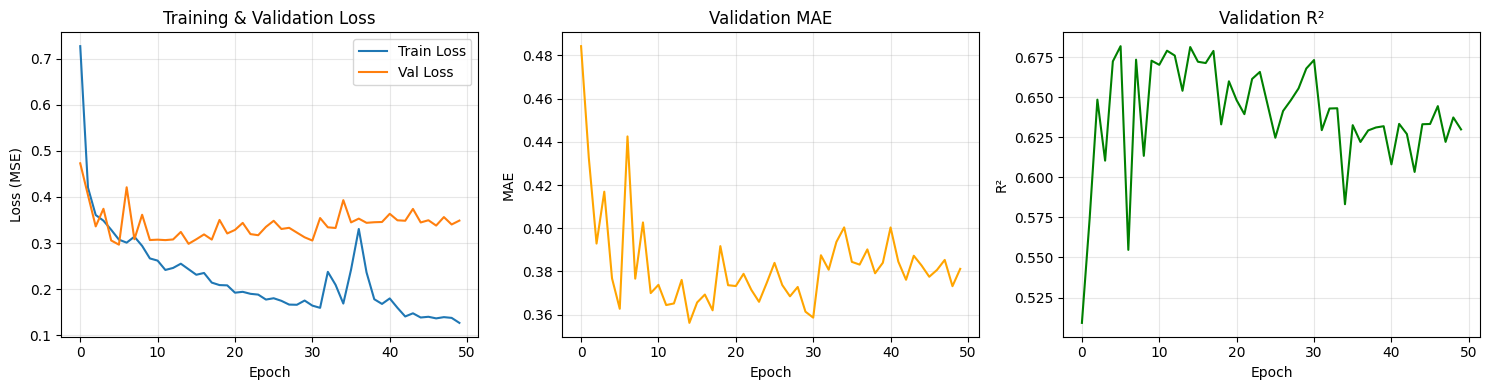

In [18]:

# 학습 곡선 시각화
plot_training_history(history)


전체 성능:
  MAE:  0.4173
  RMSE: 0.6657
  R²:   0.5716

타겟별 성능:

logKH_CO2:
  MAE:  0.5586
  RMSE: 0.7939
  R²:   0.4148

pure_uptake_CO2_298.00_15000:
  MAE:  0.5562
  RMSE: 0.8106
  R²:   0.3535

pure_uptake_methane_298.00_6500000:
  MAE:  0.1371
  RMSE: 0.2046
  R²:   0.9466


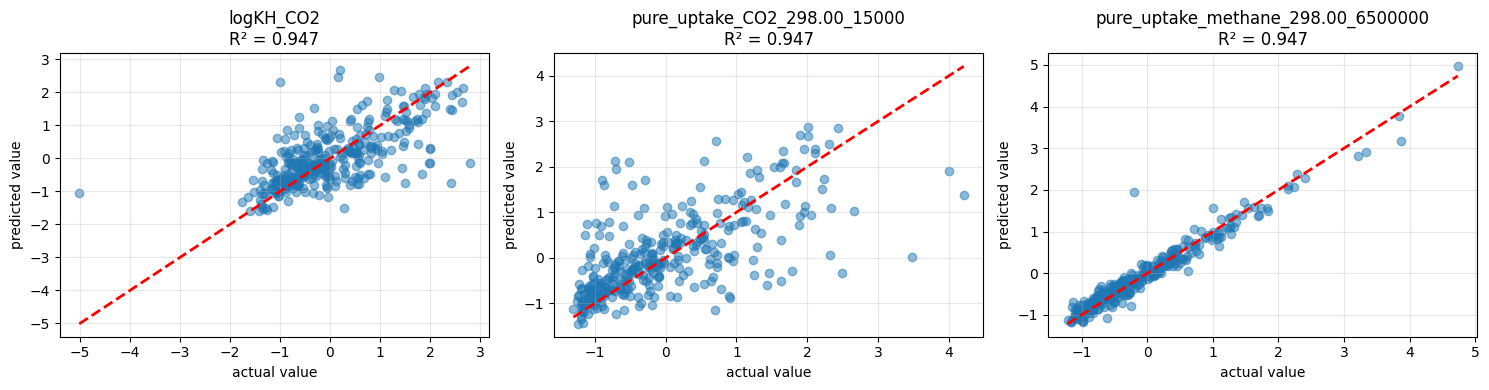

In [21]:

# 테스트셋 평가
target_names = ['logKH_CO2', 'pure_uptake_CO2_298.00_15000', 'pure_uptake_methane_298.00_6500000']
predictions, targets = evaluate_model(model, test_loader, target_names, device=device)